In [2]:
import torch
import gc

# Add memory management function
def clear_gpu_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# Clear memory at the start
clear_gpu_memory()

# PLC Chunking Strategies Comparison

This notebook allows you to experiment with and compare different chunking strategies for PLC code files (e.g., Structured Text, Instruction List) and CODESYS documentation. Add your own test files and documents in the placeholders below.

In [3]:
# Import required libraries
import re
from typing import List
from langchain.embeddings import OllamaEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.document_loaders import PyPDFLoader
import re
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import sys

In [4]:


my_pdf_filename = "/home/veysel/dev-projects/PLC-RAG-Assistant/codesys_v23_e.pdf"  # Assuming this file is in the same directory

# Correct the file_path to point to the PDF
file_path = my_pdf_filename

loader = PyPDFLoader(file_path)

# Use the synchronous load() method for simplicity in a script
loaded_pages = loader.load()

pages = ""
for page in loaded_pages:
    text = page.page_content
    # Remove any non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    pages += text

pages = re.sub(r'^.*\.{3,}.*\d+.*$', '', pages, flags=re.MULTILINE)
pages = re.sub(r'\n\s*\n', '\n\n', pages)

single_sentences_list = re.split(r'(?<=[.?!])\s+', pages)
single_sentences_list = single_sentences_list[10:]
print (f"{len(single_sentences_list)} senteneces were found")

sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]


def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentencebin the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)


6501 senteneces were found


In [11]:
sentences[10]

In [13]:
# Clear memory before loading the model
clear_gpu_memory()

In [10]:
def embedd(data):
    ollama_embed = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2",  # Much smaller model (23M vs 137M)
        show_progress=True,
        model_kwargs={'device': 'cuda'},
        encode_kwargs={'normalize_embeddings': True}
    )
    # embeddings = ollama_embed.embed_documents([x['combined_sentence'] for x in sentences])
    embeddings = ollama_embed.embed_documents(data)

    return embeddings

In [12]:
# Compare similar sentences
text1 = "Configure your PLC system"
text2 = "Set up your PLC device"
text3 = "The weather is sunny today"

embeddings = embedd([text1, text2, text3])
similarities = cosine_similarity(embeddings)
print(similarities)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[[ 1.          0.90614414  0.01947545]
 [ 0.90614414  1.         -0.00156045]
 [ 0.01947545 -0.00156045  1.        ]]


Batches:   0%|          | 0/204 [00:00<?, ?it/s]

[0.07849307455912924, 0.3837009303127257, 0.1166440553391681]


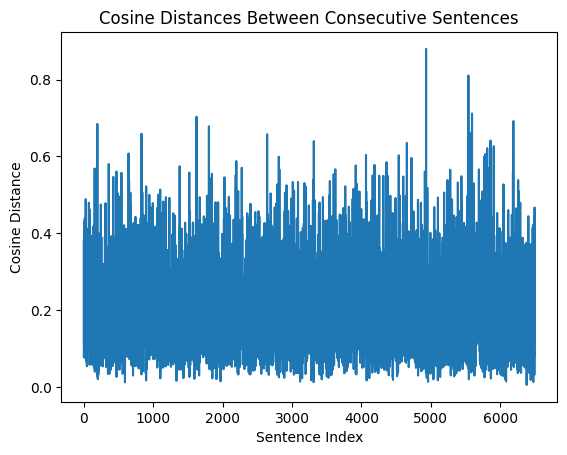

Cleaning up memory...
Script completed.


In [7]:
try:   
    # Add the embeddings to each sentence dict
    for i, sentence in enumerate(sentences):
        sentence['combined_sentence_embedding'] = embeddings[i]
    
    def calculate_cosine_distances(sentences):
        distances = []
        for i in range(len(sentences) - 1):
            embedding_current = sentences[i]['combined_sentence_embedding']
            embedding_next = sentences[i + 1]['combined_sentence_embedding']
            
            # Calculate cosine similarity
            similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
            
            # Convert to cosine distance
            distance = 1 - similarity
    
            # Append cosine distance to the list
            distances.append(distance)
    
            # Store distance in the dictionary
            sentences[i]['distance_to_next'] = distance
    
        # Optionally handle the last sentence
        # sentences[-1]['distance_to_next'] = None  # or a default value
    
        return distances, sentences
    
    distances, sentences = calculate_cosine_distances(sentences)
    print(distances[:3])
    
    plt.plot(distances)
    plt.title('Cosine Distances Between Consecutive Sentences')
    plt.xlabel('Sentence Index')
    plt.ylabel('Cosine Distance')
    plt.show()
    
except Exception as e:
    print(f"Error occurred: {e}")
    
finally:
    # Clean up at the end
    print("Cleaning up memory...")
    if 'ollama_embed' in locals():
        del ollama_embed
    if 'embeddings' in locals():
        del embeddings
    clear_gpu_memory()
    print("Script completed.")

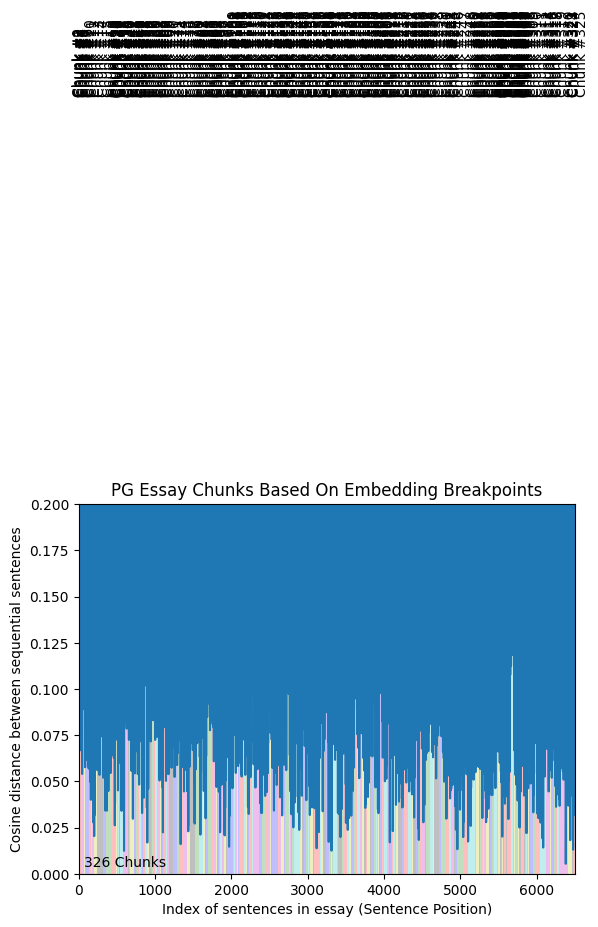

In [8]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

## 2. Define Chunking Strategies

We will implement and compare several chunking strategies:
- Fixed-size chunking (with and without overlap)
- Code-aware chunking (e.g., by function/block for PLC code)
- Recursive character/text splitting (for documentation)

In [ ]:
def fixed_size_chunking(text: str, chunk_size: int = 200, overlap: int = 50) -> List[str]:
    """Split text into fixed-size chunks with optional overlap."""
    chunks = []
    start = 0
    while start < len(text):
        end = min(start + chunk_size, len(text))
        chunks.append(text[start:end])
        start += chunk_size - overlap
    return chunks

def code_aware_chunking_st(text: str) -> List[str]:
    """Chunk Structured Text code by function or program blocks."""
    # Simple regex for FUNCTION, PROGRAM, or METHOD blocks
    pattern = r"(?=\b(FUNCTION|PROGRAM|METHOD)\b)"
    blocks = re.split(pattern, text, flags=re.IGNORECASE)
    # Re-attach block headers
    chunks = []
    for i in range(1, len(blocks), 2):
        header = blocks[i]
        body = blocks[i+1] if i+1 < len(blocks) else ''
        chunks.append(header + body)
    return [c.strip() for c in chunks if c.strip()]

def recursive_text_split(text: str, max_length: int = 300) -> List[str]:
    """Recursively split text by paragraphs, then sentences, then characters."""
    if len(text) <= max_length:
        return [text]
    # Try splitting by paragraphs
    paras = text.split('\n\n')
    if len(paras) > 1:
        return sum([recursive_text_split(p, max_length) for p in paras], [])
    # Try splitting by sentences
    sentences = re.split(r'(?<=[.!?]) +', text)
    if len(sentences) > 1:
        chunks = []
        current = ''
        for s in sentences:
            if len(current) + len(s) < max_length:
                current += ' ' + s if current else s
            else:
                if current:
                    chunks.append(current)
                current = s
        if current:
            chunks.append(current)
        return chunks
    # Fallback: character split
    return fixed_size_chunking(text, chunk_size=max_length, overlap=0)

## 3. Apply Chunking Strategies to Test Subjects

This section applies each chunking method to your test PLC code and documentation. Review the output to compare chunk boundaries and content.

In [ ]:
# Example: Apply to first PLC code sample (if available)
if plc_code_samples:
    print("--- Fixed-size chunking (PLC code) ---")
    for i, chunk in enumerate(fixed_size_chunking(plc_code_samples[0])):
        print(f"Chunk {i+1}:\n{chunk}\n---")
    print("\n--- Code-aware chunking (Structured Text) ---")
    for i, chunk in enumerate(code_aware_chunking_st(plc_code_samples[0])):
        print(f"Chunk {i+1}:\n{chunk}\n---")
else:
    print("No PLC code samples provided.")

# Example: Apply to first CODESYS doc excerpt (if available)
if codesys_docs:
    print("\n--- Fixed-size chunking (CODESYS doc) ---")
    for i, chunk in enumerate(fixed_size_chunking(codesys_docs[0])):
        print(f"Chunk {i+1}:\n{chunk}\n---")
    print("\n--- Recursive text split (CODESYS doc) ---")
    for i, chunk in enumerate(recursive_text_split(codesys_docs[0])):
        print(f"Chunk {i+1}:\n{chunk}\n---")
else:
    print("No CODESYS documentation excerpts provided.")

## 4. Compare and Evaluate

- Review the output chunks for each method and test subject.
- Consider: Are code blocks preserved? Are documentation chunks semantically meaningful?
- Add your own notes and observations below.